In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.models import Model,Sequential
from keras.layers import Conv2D,MaxPooling2D,BatchNormalization,Input,Conv2DTranspose,Dropout,concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model, load_model

In [ ]:
keras.backend.set_image_data_format('channels_last')

In [ ]:
IMG_DIR = '/content/drive/MyDrive/vinecuttings/images'
MASK_DIR = '/content/drive/MyDrive/vinecuttings/masks'

images = [os.path.join(IMG_DIR, x) for x in sorted(os.listdir(IMG_DIR))]
masks = [os.path.join(MASK_DIR, x) for x in sorted(os.listdir(MASK_DIR))]

In [ ]:
IMG_HEIGHT = 512
IMG_WIDTH = 512
IMG_CHANNELS = 3

X = np.zeros((len(images), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype = np.float32)
y = np.zeros((len(masks), IMG_HEIGHT, IMG_WIDTH, 1), dtype = bool)

In [ ]:
for file in images:
    n = images.index(file)
    imag = cv2.imread(file,1)
    imag = cv2.resize(imag, (512,512))
    try:
        X[n] = imag/255.0
        file2 = masks[n]
        mask = cv2.imread(file2, 1)
        mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
        mask=cv2.resize(mask,(512,512))
        mask=np.expand_dims(mask,axis=2)
        y[n] = mask/255
    except Exception as e:
        print(e)

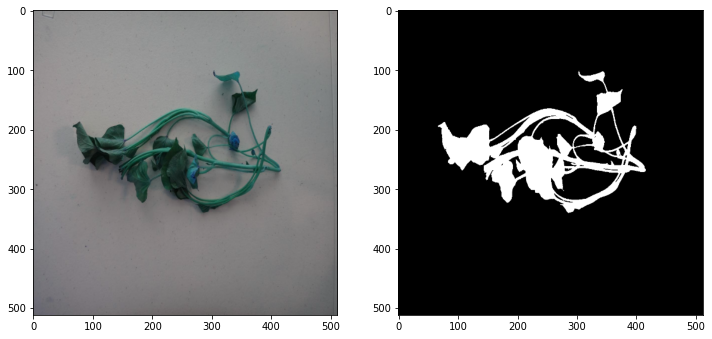

In [ ]:
i = np.random.randint(0,60)
imag = cv2.imread(images[i],1)
imag = cv2.resize(imag, (512,512))


mas = cv2.imread(masks[i],1)
mas = cv2.resize(mas, (512,512))
mas = cv2.cvtColor(mas, cv2.COLOR_RGB2GRAY)
mas = np.float32(mas)

fig, (ax0, ax1) = plt.subplots(1,2, figsize=(12,9))
ax0.imshow(imag)
ax1.imshow(mas, cmap='gray')

In [ ]:
X_train = X[:56]
X_val = X[56:]
y_train = y[:56]
y_val = y[56:]

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
seed=24
img_data_gen_args=dict(rotation_range=90,
                       shear_range=0.3,
                       zoom_range=0.2,
                       horizontal_flip=True,
                       vertical_flip=True,
                       fill_mode='nearest')

mask_data_gen_args=dict(rotation_range=90,
                       shear_range=0.3,
                       zoom_range=0.2,
                       horizontal_flip=True,
                       vertical_flip=True,
                       fill_mode='nearest',
                       preprocessing_function=lambda x: np.where(x>0,1,0).astype(x.dtype))

In [ ]:
batch_size=4

In [ ]:
image_data_generator = ImageDataGenerator(**img_data_gen_args)

train_image_generator = image_data_generator.flow(X_train,
                                            batch_size = batch_size,
                                            seed = seed)

valid_image_generator = image_data_generator.flow(X_val,
                                            batch_size = batch_size,
                                            seed = seed)

mask_data_generator = ImageDataGenerator(**mask_data_gen_args)

train_mask_generator = mask_data_generator.flow(y_train,
                                                batch_size = batch_size,
                                                seed = seed)

valid_mask_generator = mask_data_generator.flow(y_val,
                                                batch_size = batch_size,
                                                seed = seed)

In [ ]:
def my_image_mask_gen(image_generator, mask_generator):
    generator = zip(image_generator, mask_generator)
    for (img, mask) in generator:
        yield (img, mask)

train_generator = my_image_mask_gen(train_image_generator, train_mask_generator)
valid_generator = my_image_mask_gen(valid_image_generator, valid_mask_generator)

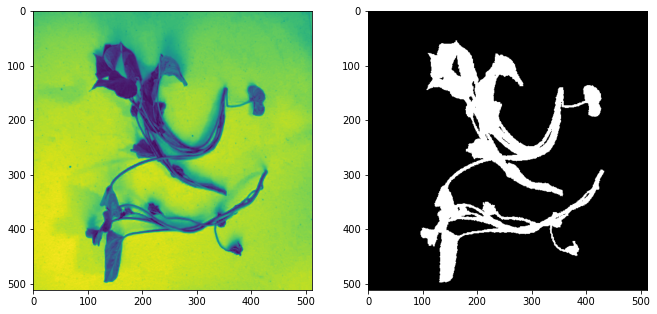

In [ ]:
x=train_image_generator.next()
y=train_mask_generator.next()
for i in range(0,1):
  image=x[i]
  mask=y[i]
  plt.figure(figsize=(11,8))
  plt.subplot(1,2,1)
  plt.imshow(image[:,:,0])
  plt.subplot(1,2,2)
  plt.imshow(mask[:,:,0], cmap = 'gray')

In [ ]:
inputs=tf.keras.layers.Input((512,512,3))

s = inputs

c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = Dropout(0.2)(c1)  # Original 0.1
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = MaxPooling2D((2, 2))(c1)


c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = Dropout(0.2)(c2)  # Original 0.1
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)


u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c2)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = Dropout(0.2)(c9)  # Original 0.1
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)



outputs = Conv2D(1,(1, 1),activation='sigmoid')(c9)

model = Model(inputs=[inputs], outputs=[outputs])

In [ ]:
EarlyStop = EarlyStopping(patience = 5,restore_best_weights=True)
Checkpoint = ModelCheckpoint('unet_model.h5',save_best_only=True)


model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history=model.fit(train_generator,validation_data=valid_generator,epochs=10,
                  steps_per_epoch=len(train_image_generator)//batch_size,
                  validation_steps=len(train_mask_generator)//batch_size,
                  callbacks=[EarlyStop,Checkpoint])

Epoch 1/10
3/3 [==============================] - 9s 942ms/step - loss: 0.4839 - accuracy: 0.8315 - val_loss: 0.3504 - val_accuracy: 0.8950
Epoch 2/10
3/3 [==============================] - 2s 921ms/step - loss: 0.2806 - accuracy: 0.8922 - val_loss: 0.2645 - val_accuracy: 0.8935
Epoch 3/10
3/3 [==============================] - 2s 945ms/step - loss: 0.3268 - accuracy: 0.8733 - val_loss: 0.2561 - val_accuracy: 0.9008
Epoch 4/10
3/3 [==============================] - 2s 924ms/step - loss: 0.3495 - accuracy: 0.8594 - val_loss: 0.2475 - val_accuracy: 0.9006
Epoch 5/10
3/3 [==============================] - 2s 1s/step - loss: 0.2842 - accuracy: 0.8816 - val_loss: 0.2735 - val_accuracy: 0.8901
Epoch 6/10
3/3 [==============================] - 2s 1s/step - loss: 0.2609 - accuracy: 0.8842 - val_loss: 0.2716 - val_accuracy: 0.8978
Epoch 7/10
3/3 [==============================] - 2s 877ms/step - loss: 0.2857 - accuracy: 0.8710 - val_loss: 0.2747 - val_accuracy: 0.8832
Epoch 8/10
3/3 [==========

In [ ]:
"""

def plot_img(img, mas):

    img = cv2.imread(img)
    img = cv2.resize(img, (512,512))
    img = img / 255.0
    img = img.astype(np.float32)

    mas = cv2.imread(mas,0)
    mas = cv2.resize(mas, (512,512))
    mas = np.float32(mas)

    y_pred = model.predict(np.expand_dims(img, axis=0))
    y_pred = cv2.resize(y_pred[0], (512,512))

    fig, (ax0, ax1,ax2) = plt.subplots(1,3, figsize=(17,8))
    ax0.imshow(img)
    ax1.imshow(mas, cmap = 'gray')
    ax2.imshow(y_pred, cmap = 'gray')

"""

"\n\ndef plot_img(img, mas):\n    \n    img = cv2.imread(img)\n    img = cv2.resize(img, (512,512))\n    img = img / 255.0\n    img = img.astype(np.float32)\n    \n    mas = cv2.imread(mas,0)\n    mas = cv2.resize(mas, (512,512))\n    mas = np.float32(mas)\n\n    y_pred = model.predict(np.expand_dims(img, axis=0))\n    y_pred = cv2.resize(y_pred[0], (512,512))\n    \n    fig, (ax0, ax1,ax2) = plt.subplots(1,3, figsize=(17,8))\n    ax0.imshow(img)\n    ax1.imshow(mas, cmap = 'gray')\n    ax2.imshow(y_pred, cmap = 'gray')\n  \n"

In [ ]:
"""
for i in range(56,60):
    plot_img(images[i], masks[i])

"""

'\nfor i in range(56,60):\n    plot_img(images[i], masks[i])\n\n'

(-0.5, 511.5, 511.5, -0.5)

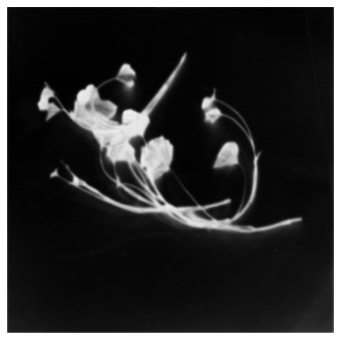

In [ ]:
i = np.random.randint(56,60)

img = images[i]

img = cv2.imread(img)
img = cv2.resize(img, (512,512))
img = img / 255.0
img = img.astype(np.float32)

y_pred = model.predict(np.expand_dims(img, axis=0))
y_pred = cv2.resize(y_pred[0], (512,512))

plt.figure(figsize=(8,6))
plt.imshow(y_pred, cmap='gray')
plt.axis('off')

In [ ]:
from skimage.measure import regionprops, regionprops_table, label
from skimage.color import label2rgb
from skimage import filters

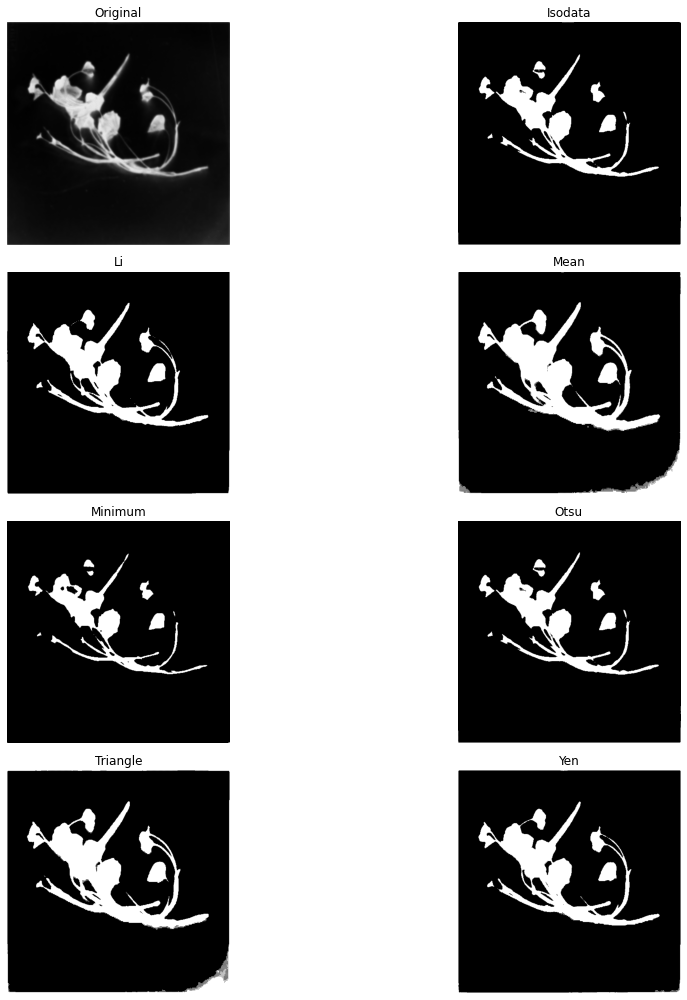

In [ ]:
img = y_pred

fig, ax = filters.try_all_threshold(img, figsize=(16,14), verbose = False)

plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  This is separate from the ipykernel package so we can avoid doing imports until


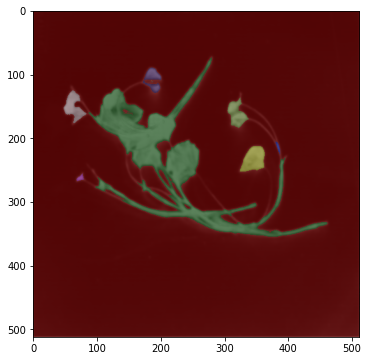

In [ ]:
threshold = filters.threshold_otsu(img)
img_thresh = label(img > threshold)
img_overlay = label2rgb(img_thresh, image=img)

plt.figure(figsize=(8,6))
plt.imshow(img_overlay)

In [ ]:
from skimage import measure
props = regionprops_table(
    img_thresh, img,
    properties = [
        'label',
        'area', 'equivalent_diameter',
        'solidity','mean_intensity'
    ]
)

In [ ]:
import pandas as pd

df = pd.DataFrame(props)
df.head()

,label,area,equivalent_diameter,solidity,mean_intensity
0,1,2,1.595769,1.0,0.257427
1,2,1,1.128379,1.0,0.222467
2,3,1,1.128379,1.0,0.228556
3,4,1,1.128379,1.0,0.225209
4,5,1,1.128379,1.0,0.223130


In [ ]:
df.shape

(52, 5)

In [ ]:
c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = Dropout(0.2)(c3)
c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)


u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c3)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = Dropout(0.2)(c8)  # Original 0.1
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

NameError: ignored